## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [2]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need
train_data['purchase'].unique()

array([0, 1], dtype=int64)

In [4]:
#Total Numeber of users
train_data.shape[0]

84534

In [5]:
#Experiment Set
train_data[train_data["Promotion"]=="Yes"].shape[0]#number of users who received promotion Experiment set

42364

In [6]:
#Control set
train_data[train_data["Promotion"]=="No"].shape[0]#number of users who did not received promotion  Control set 

42170

In [7]:
#number of purchaser who received promotion
train_data[(train_data["Promotion"]=="Yes")&(train_data["purchase"]==1)].shape[0]

721

In [8]:
#number of purchaser in the non promotional group
train_data[(train_data["Promotion"]=="No")&(train_data["purchase"]==1)].shape[0]

319

In [9]:
# Filter the columns to remove data we do not want 
columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6','V7']
# Store the variable we are predicting 
target = "purchase"
# Define a random state 
state = np.random.RandomState(42)
X = train_data[columns]
Y = train_data[target]
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(84534, 7)
(84534,)


In [10]:
train_data.columns

Index(['ID', 'Promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7'],
      dtype='object')

## 1. Function to find IRR
$$IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}}$$


In [11]:
#Incremental Response Rate (IRR)
def getirr(train_data):
    T_purch=train_data[(train_data["Promotion"]=="Yes")&(train_data["purchase"]==1)].shape[0]
    print("Treated purchase :  ", T_purch)
    T_cust=train_data[(train_data["Promotion"]=="Yes")].shape[0]
    print("Treated Customer :  ", T_cust)
    C_purch=train_data[(train_data["Promotion"]=="No")&(train_data["purchase"]==1)].shape[0]
    print("Control purchase :  ", C_purch)
    C_cust=train_data[(train_data["Promotion"]=="No")].shape[0]
    print("Control Customer :  ", C_cust)
    irr=(T_purch/T_cust)-(C_purch/C_cust)
    print("Incremental Response Rate (IRR) :",irr)


In [12]:
getirr(train_data)

Treated purchase :   721
Treated Customer :   42364
Control purchase :   319
Control Customer :   42170
Incremental Response Rate (IRR) : 0.009454547819772702


In [13]:
irr=(721/32170)-(319/52170)
irr
# by decreasing the treated customer we can increase the incremental response rate

0.016297560002214134

## 2. Function to find Net Incremental Revenue (NIR)
$$NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


In [14]:
#function to find NIR
def getnir(train_data,priceofproduct,costperpromotion):
    T_purch=train_data[(train_data["Promotion"]=="Yes")&(train_data["purchase"]==1)].shape[0]
    print("Treated purchase :  ", T_purch)
    T_cust=train_data[(train_data["Promotion"]=="Yes")].shape[0]
    print("Treated Customer :  ", T_cust)
    C_purch=train_data[(train_data["Promotion"]=="No")&(train_data["purchase"]==1)].shape[0]
    print("Control purchase :  ", C_purch)
    NIR=((priceofproduct*T_purch)-(costperpromotion*T_cust))-(priceofproduct*C_purch)
    print("price of product: ",priceofproduct)
    print("cost per promotion: ",costperpromotion)
    print("Net Incremental Revenue (NIR) :", NIR)
    

In [15]:
getnir(train_data,10,0.15)

Treated purchase :   721
Treated Customer :   42364
Control purchase :   319
price of product:  10
cost per promotion:  0.15
Net Incremental Revenue (NIR) : -2334.5999999999995


### 3. Problem Formulation

- In this Notebook, we want to investigate "what factors/variables affect NIR and IRR and find a way to increase those metrics"
- Make predictions on howlikely is the customer is going to purchase the product if we send the promotion
- Hence our Dependent variable (y) is the purchase prediction (Yes/No) or if the customer will by or not buy the product
-By increasing the number of purchase conversion in our experimental set by predicting the purchase behaviour of our customer we can increase the KPI metrics.(refer the formula)

In [16]:
train_data

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...
84529,126180,No,0,1,30.084876,1.345672,1,1,3,1
84530,126181,Yes,0,3,33.501485,-0.299306,1,1,4,1
84531,126182,No,0,1,31.492019,1.085939,2,3,2,2
84532,126183,No,0,1,37.766106,0.999361,2,2,1,2


## 4. Data Preprocessing

### 4.1. Exploratory Data Analysis

In [17]:
# Checking for null values

train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [18]:
# Investigate all the elements whithin each Feature 

for column in train_data:
    unique_values = np.unique(train_data[column])
    nr_values = len(unique_values)
    if nr_values <= 10:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature ID is: 84534
The number of values for feature Promotion is: 2 -- ['No' 'Yes']
The number of values for feature purchase is: 2 -- [0 1]
The number of values for feature V1 is: 4 -- [0 1 2 3]
The number of values for feature V2 is: 84518
The number of values for feature V3 is: 40
The number of values for feature V4 is: 2 -- [1 2]
The number of values for feature V5 is: 4 -- [1 2 3 4]
The number of values for feature V6 is: 4 -- [1 2 3 4]
The number of values for feature V7 is: 2 -- [1 2]


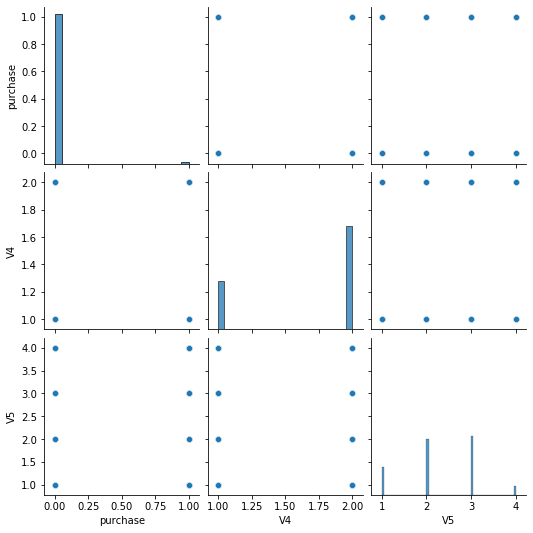

In [19]:
# Visualize the data using seaborn Pairplots
g = sb.pairplot(train_data[['purchase','Promotion','V4','V5']])


From our observation we can clearly see that the purchase column is imbalanced

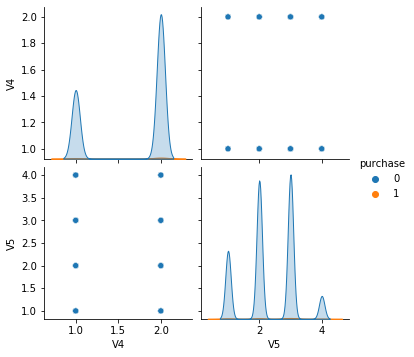

In [20]:
g = sb.pairplot(train_data[['purchase','Promotion','V4','V5']], hue = 'purchase')


From our observation we can clearly see that the purchase column is imbalanced, and it is heavilym baised as there are a lot of non purchasers. 

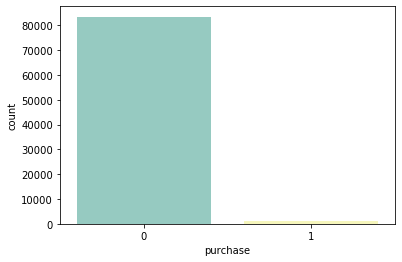

In [22]:
# Investigating the distr of y

sb.countplot(x = 'purchase', data = train_data, palette = 'Set3')

### We need to find a way to balance this dataset, or the machine learning model will be baised towards  "0". 

We can try over sampling on "1".

#### RandomOverSampler to handle imbalanced data


In [23]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [24]:
from imblearn.over_sampling import RandomOverSampler

#### SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).

In [25]:
os_us = SMOTETomek()

X_train_res1, y_train_res1 = os_us.fit_resample(X, Y)

In [26]:
X_train_res1.shape,y_train_res1.shape


((166396, 7), (166396,))

In [28]:
from collections import Counter

print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res1)))

Original dataset shape Counter({0: 83494, 1: 1040})
Resampled dataset shape Counter({0: 83198, 1: 83198})


In [29]:
frame=X_train_res1.join(y_train_res1)
frame

,V1,V2,V3,V4,V5,V6,V7,purchase
0,2,30.443518,-1.165083,1,1,3,2,0
1,3,32.159350,-0.645617,2,3,2,2,0
2,2,30.431659,0.133583,1,1,4,2,0
3,0,26.588914,-0.212728,2,1,4,2,0
4,3,28.044332,-0.385883,1,1,2,2,0
...,...,...,...,...,...,...,...,...
166391,1,26.478956,-1.124768,2,3,3,2,1
166392,2,25.304074,0.030447,2,1,4,2,1
166393,1,28.196544,0.733947,1,2,4,1,1
166394,0,27.787161,0.784040,1,3,2,1,1


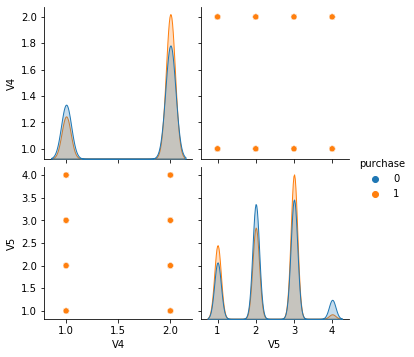

In [30]:
g = sb.pairplot(frame[['purchase','V4','V5']], hue ='purchase')

### 5.3. Feature Selection
Steps of Running Feature Importance
- Split the data into X & y
- Run a Tree-based estimators (i.e. decision trees & random forests)
- Run Feature Importance


In [41]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X_train_res1, y_train_res1)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=15)

In [42]:
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(X_train_res1):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for V1 is : 0.08959945124363367
The feature importance for V2 is : 0.2031355338524125
The feature importance for V3 is : 0.4267621252529476
The feature importance for V4 is : 0.05929231977743052
The feature importance for V5 is : 0.11730929456172148
The feature importance for V6 is : 0.07033473537237485
The feature importance for V7 is : 0.033566539939479605


In [43]:
# Creating a Dataframe
fi_col
fi

fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = fi_df['Feature'][0:40]

fi_df

,index,Feature,Feature Importance
0,2,V3,0.426762
1,1,V2,0.203136
2,4,V5,0.117309
3,0,V1,0.089599
4,5,V6,0.070335
5,3,V4,0.059292
6,6,V7,0.033567


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res1, y_train_res1, train_size = 0.8, test_size=0.2, random_state=15)
print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)



(133116, 7)
(33280, 7)
(133116,)
(33280,)


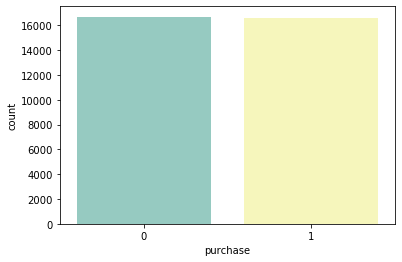

In [47]:
#checking the distribution of y_Train, y_test
ax = sb.countplot(x = y_test, palette = "Set3")

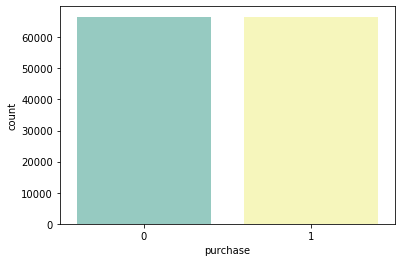

In [48]:
ax = sb.countplot(x = y_train, palette = "Set3")

#### Applying Logistic Regression to predict the purchase behaviour

In [49]:
# Training my model

log_reg = LogisticRegression(random_state=10, solver = 'lbfgs')

log_reg.fit(X_train,y_train)

LogisticRegression(random_state=10)

In [51]:
#X_test=X_test[['V3','V2','V5']]
y_pred=log_reg.predict(X_test)
pred_proba = log_reg.predict_proba(X_test)
print(y_pred)
print(pred_proba)
# coef_ - Coefficient of the features in the decision function
log_reg.coef_


[1 1 1 ... 1 0 1]
[[0.49303166 0.50696834]
 [0.45335629 0.54664371]
 [0.34425293 0.65574707]
 ...
 [0.35232545 0.64767455]
 [0.54927535 0.45072465]
 [0.34875502 0.65124498]]


array([[-0.26686993, -0.00581715, -0.06461565,  0.49259553, -0.09627187,
        -0.13126983, -0.31034177]])

In [52]:
# Accuracy on Train
#print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))


# Classification Report
print(classification_report(y_test, y_pred))


The Testing Accuracy is:  0.5716947115384615
              precision    recall  f1-score   support

           0       0.57      0.57      0.57     16695
           1       0.57      0.57      0.57     16585

    accuracy                           0.57     33280
   macro avg       0.57      0.57      0.57     33280
weighted avg       0.57      0.57      0.57     33280



In [53]:
# Confusion Matrix function

def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sb.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sb.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

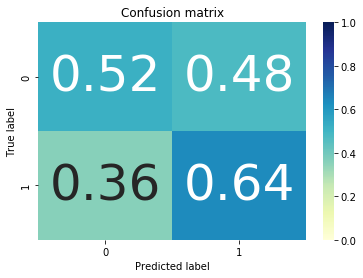

In [70]:
# Visualizing cm

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

In [55]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)

FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
print("The True Positive Rate is:", TPR)

# Precision or positive predictive value
PPV = TP / (TP + FP)
print("The Precision is:", PPV)

# False positive rate or False alarm rate
FPR = FP / (FP + TN)
print("The False positive rate is:", FPR)


# False negative rate or Miss Rate
FNR = FN / (FN + TP)
print("The False Negative Rate is: ", FNR)



##Total averages :
print("")
print("The average TPR is:", TPR.sum()/2)
print("The average Precision is:", PPV.sum()/2)
print("The average False positive rate is:", FPR.sum()/2)
print("The average False Negative Rate is:", FNR.sum()/2)


The True Positive Rate is: [0.57112908 0.57226409]
The Precision is: [0.57339587 0.5699958 ]
The False positive rate is: [0.42773591 0.42887092]
The False Negative Rate is:  [0.42887092 0.42773591]

The average TPR is: 0.5716965873119706
The average Precision is: 0.5716958353625274
The average False positive rate is: 0.4283034126880294
The average False Negative Rate is: 0.4283034126880294


In [56]:
# Running Log loss on testing
pred_proba_t = log_reg.predict_proba(X_test)
print("The Log Loss on Testing Dataset is: ", log_loss(y_test, pred_proba_t))

The Log Loss on Testing Dataset is:  0.6749847712396617


### 10. Hyper Parameter Tuning


In [57]:
np.geomspace(1e-5, 1e5, num=20)

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

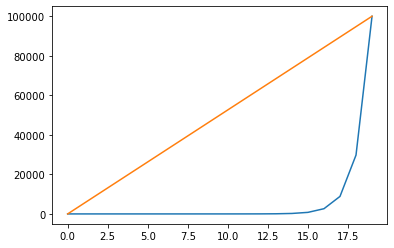

In [58]:
# Creating a range for C values
np.geomspace(1e-5, 1e5, num=20)

# ploting it
plt.plot(np.geomspace(1e-5, 1e5, num=20)) #  uniformly distributed in log space
plt.plot(np.linspace(1e-5, 1e5, num=20)) # uniformly distributed in linear space, instead of log space
# plt.plot(np.logspace(np.log10(1e-5) , np.log10(1e5) , num=20)) # same as geomspace

In [59]:
# Looping over the parameters

C_List = np.geomspace(1e-5, 1e5, num=20)
CA = []
Logarithmic_Loss = []

for c in C_List:
    log_reg2 = LogisticRegression(random_state=10, solver = 'lbfgs', C=c)
    log_reg2.fit(X_train, y_train)
    score = log_reg2.score(X_test, y_test)
    CA.append(score)
    print("The CA of C parameter {} is {}:".format(c, score))
    pred_proba_t = log_reg2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    Logarithmic_Loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")

The CA of C parameter 1e-05 is 0.5603064903846153:
The Logg Loss of C parameter 1e-05 is 0.6883522939324832:

The CA of C parameter 3.359818286283781e-05 is 0.565234375:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.6833014072306113:

The CA of C parameter 0.00011288378916846884 is 0.5646935096153847:
The Logg Loss of C parameter 0.00011288378916846884 is 0.6784202234972376:

The CA of C parameter 0.000379269019073225 is 0.5693209134615385:
The Logg Loss of C parameter 0.000379269019073225 is 0.6758070079449897:

The CA of C parameter 0.0012742749857031334 is 0.5710036057692308:
The Logg Loss of C parameter 0.0012742749857031334 is 0.6751102766067739:

The CA of C parameter 0.004281332398719391 is 0.571123798076923:
The Logg Loss of C parameter 0.004281332398719391 is 0.6750026905559824:

The CA of C parameter 0.01438449888287663 is 0.5713942307692308:
The Logg Loss of C parameter 0.01438449888287663 is 0.6749875380877707:

The CA of C parameter 0.04832930238571752 is 0.57148

In [60]:
# putting the outcomes in a Table

# reshaping
CA2 = np.array(CA).reshape(20,)
Logarithmic_Loss2 = np.array(Logarithmic_Loss).reshape(20,)

# zip
outcomes = zip(C_List, CA2, Logarithmic_Loss2)

#df
df_outcomes = pd.DataFrame(outcomes, columns = ["C_List", 'CA2','Logarithmic_Loss2'])

#print
df_outcomes

# Ordering the data (sort_values)
df_outcomes.sort_values("Logarithmic_Loss2", ascending = True).reset_index()

,index,C_List,CA2,Logarithmic_Loss2
0,18,29763.514416,0.571635,0.674984
1,9,0.545559,0.571725,0.674984
2,14,233.572147,0.571665,0.674985
3,19,100000.000000,0.571665,0.674985
4,17,8858.667904,0.571665,0.674985
5,10,1.832981,0.571575,0.674985
6,15,784.759970,0.571575,0.674985
7,11,6.158482,0.571665,0.674985
8,16,2636.650899,0.571575,0.674985
9,13,69.519280,0.571635,0.674986


In [61]:
# Another way of doing the above
# Scikit-learn offers a LogisticRegressionCV module which implements Logistic Regression 
# with builtin cross-validation to find out the optimal C parameter

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=0, shuffle=True)

# Logistic Reg CV
Log_reg3 = LogisticRegressionCV(random_state=15, Cs = C_List, solver ='lbfgs')
Log_reg3.fit(X_train, y_train)
print("The CA is:", Log_reg3.score(X_test, y_test))
pred_proba_t = Log_reg3.predict_proba(X_test)
log_loss3 = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_loss3)

print("The optimal C parameter is: ", Log_reg3.C_)




The CA is: 0.5716045673076923
The Logistic Loss is:  0.6749922915376918
The optimal C parameter is:  [0.16237767]


In [62]:
# Training a Dummy Classifier

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
score = dummy_clf.score(X_test, y_test)

pred_proba_t = dummy_clf.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)



Testing Acc: 0.4983473557692308
Log Loss: 17.32646850700222


In [63]:
log_reg3 = LogisticRegression(random_state=10, solver = 'lbfgs', C=0.16237767)
log_reg3.fit(X_train, y_train)
score = log_reg3.score(X_test, y_test)

pred_proba_t = log_reg3.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.5715745192307692
Log Loss: 0.6749859091701137


#### Using support vector machine to classify data

In [66]:
from sklearn import svm

svm_m = svm.SVC()
svm_m.fit(X_train,y_train)
y_pred=svm_m.predict(X_test)



AttributeError: predict_proba is not available when  probability=False

In [69]:
print("The Testing Accuracy is: ", svm_m.score(X_test, y_test))


# Classification Report
print(classification_report(y_test, y_pred))

The Testing Accuracy is:  0.5794771634615384
              precision    recall  f1-score   support

           0       0.59      0.52      0.55     16695
           1       0.57      0.64      0.60     16585

    accuracy                           0.58     33280
   macro avg       0.58      0.58      0.58     33280
weighted avg       0.58      0.58      0.58     33280



In [67]:
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [68]:
y_pred=svm_m.predict(X_test)
